In [3]:
import numpy as np
import os, sys, librosa, math
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import IPython.display as ipd
import pandas as pd
import librosa, librosa.display

from utils.feature_tools import normalize_feature_sequence, smooth_downsample_feature_sequence, median_downsample_feature_sequence
from utils.plot_tools import plot_matrix, compressed_gray_cmap, plot_chromagram
from utils.structure_tools import *

C:\Users\Cho\anaconda3\envs\mir\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# 오디오 썸네일링 (Audio Thumbnailing)

- 음악 구조 분석의 두드러진 하위 문제는 **오디오 썸네일링(thumbnailing)** 으로 알려져 있다. 
- 음악 녹음에서 목적은 가장 대표적인 섹션을 자동으로 결정하는 것이며, 이는 청취자에게 노래 또는 음악 작품에 대한 첫인상을 주는 일종의 "미리 보기" 역할을 할 수 있다. 
- 이러한 미리 보기를 기반으로 사용자는 노래를 듣고 싶은지 또는 다음 녹음으로 이동할지 빠르게 결정할 수 있어야 한다. 
- 따라서 오디오 썸네일은 대규모 음악 컬렉션에서 흥미로운 부분을 찾는 데 중요한 탐색 및 탐색 보조 도구이다. 이 노트북에서는 **반복 기반 접근 방식(repetition-based approach)** 을 설명한다.

- 종종 후렴구 또는 노래의 메인 테마와 같은 섹션은 오디오 썸네일의 좋은 후보이다. 이러한 부분은 일반적으로 녹음 내내 여러 번 반복된다. 
- 따라서 썸네일을 자동으로 결정하기 위해 대부분의 절차는 한편으로는 특정 최소 기간이 있고 다른 한편으로는 **많은 (대략적인) 반복**이 있는 섹션을 식별한다. 
- 다음 그림은 서양 음악에서 볼 수 있는 음악 구조의 몇 가지 예를 보여준다. 
    - 론도는 당연히 썸네일 후보가 테마(A파트)입니다. 소나타에서 제시부의 시작 부분(파트 E1, E2 및 R에서 발생)은 적절한 축소판일 수 있다. '예스터데이'와 같은 팝송은 벌스 섹션(V1 파트)이 특징이다. 마지막으로 이전 노트북에서 실행 예제로 이미 봤던 Brahms 예제에서 A 파트 또는 B 파트를 썸네일로 선택할 수 있다.

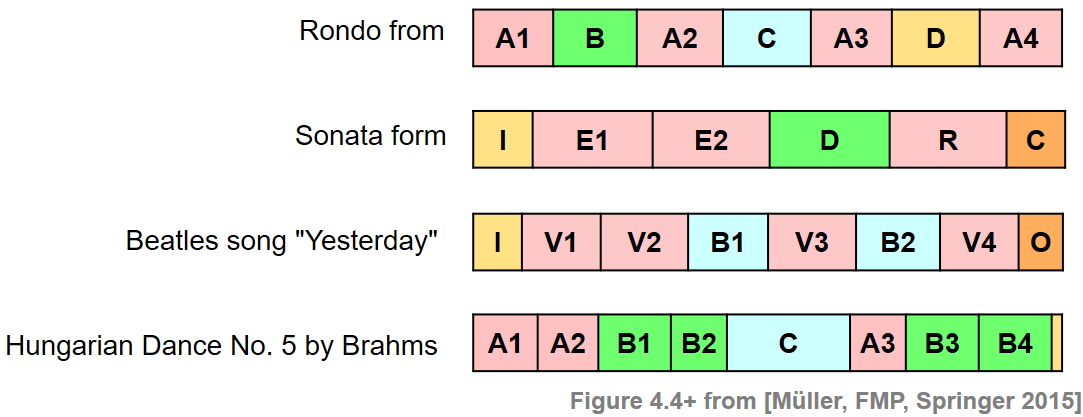

In [4]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_F04+.png", width=500)

- 한 가지 문제는 반복되는 섹션이 다이나믹(dynamics), 악기 편성, 아티큘레이션 및 템포와 관련된 측면에서 상당한 음향 및 음악적 차이를 보일 수 있다는 것이다. 
- 따라서 주어진 음악 녹음에서 반복적인 세그먼트를 추출하기 위한 썸네일링 절차는 특정 변형에 robust해야 한다. 

- 이제 음악적, 템포적인 변동을 다루기 위해, 향상된 자기 유사성 행렬(SSM)과 타임 워핑(time warping) 기술을 기반으로 하는 절차를 설명한다. 주요 기술 도구로 각 오디오 세그먼트에 적합도(fitness) 값을 할당하는 **fitness measure**를 소개한다. 이 측정은 두 가지 측면을 동시에 포착한다. 첫째, 주어진 세그먼트가 다른 관련 세그먼트를 **얼마나 잘** 설명하는지를 나타내고, 둘째, 이러한 모든 관련 세그먼트가 전체 음악 녹음의 **얼마나 많은** 부분을 포함하는지 나타낸다. 그런 다음 **오디오 썸네일**은 **최대 피트니스 세그먼트**로 정의된다.

## Requirements on SSM

- 적합도(fitness) 측정의 아이디어는 주어진 세그먼트와 그것의 대략적인 반복 간의 모든 관계를 동시에 설정하는 것이다. 이를 위해서는 **자기 유사성 행렬(SSM)** 이 필요하다. 적합도 측정에 대한 다음 설명은 일부 기본 **정규화 속성(normalization properties)** 만 충족하는 일반 자기 유사성 행렬과 함께 작동한다는 점에서 일반적이다. 
- $ \mathbf{S}(n,m)\leq 1$ and $\mathbf{S}(n,n)=1$ for all $n,m\in[1:N]$


- 5.2.에서 사용한 브람스 예시를 계속하여, 향상된(enhanced) SSM에서 시작하여 정규화 속성을 만족시키는 임계값 절차(thresholding procedure)을 거친다. 결과적으로 SSM의 모든 관련된(relevant) 성분은 0과 1 사이(주대각선 성분은 1)가 되며, 관련없는 성분은 $\delta=-2$의 음수 점수를 가진다.

In [5]:
def colormap_penalty(penalty=-2, cmap=compressed_gray_cmap(alpha=5)):
    """Extend colormap with white color between the penalty value and zero

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        penalty (float): Negative number (Default value = -2.0)
        cmap (mpl.colors.Colormap): Original colormap (Default value = libfmp.b.compressed_gray_cmap(alpha=5))

    Returns:
        cmap_penalty (mpl.colors.Colormap): Extended colormap
    """
    if isinstance(cmap, str):
        cmap = matplotlib.cm.get_cmap(cmap, 128)
    cmap_matrix = cmap(np.linspace(0, 1, 128))[:, :3]
    num_row = int(np.abs(penalty)*128)
    # cmap_penalty = np.flip(np.concatenate((cmap_matrix, np.ones((num_row, 3))), axis=0), axis=0)
    cmap_penalty = np.concatenate((np.ones((num_row, 3)), cmap_matrix), axis=0)
    cmap_penalty = ListedColormap(cmap_penalty)

    return cmap_penalty


def normalization_properties_ssm(S):
    """Normalizes self-similartiy matrix to fulfill S(n,n)=1.
    Yields a warning if max(S)<=1 is not fulfilled

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        S (np.ndarray): Self-similarity matrix (SSM)

    Returns:
        S_normalized (np.ndarray): Normalized self-similarity matrix
    """
    S_normalized = S.copy()
    N = S_normalized.shape[0]
    for n in range(N):
        S_normalized[n, n] = 1
        max_S = np.max(S_normalized)
    if max_S > 1:
        print('Normalization condition for SSM not fulfill (max > 1)')
    return S_normalized

In [6]:
tempo_rel_set = compute_tempo_rel_set(0.66, 1.5, 5)
penalty = -2

import audioread
fn_mp3 = audioread.ffdec.FFmpegAudioFile('../audio/brahms_hungarian_dance_5.mp3')

x, x_duration, X, Fs_feature, S, I = compute_sm_from_filename(fn_mp3, L=21, H=5, 
                        L_smooth=12, tempo_rel_set=tempo_rel_set, penalty=penalty, thresh= 0.15)
S = normalization_properties_ssm(S)
 
cmap_penalty = colormap_penalty(penalty=penalty)

C:\Users\Cho\Documents\GitHub\mir\Notebooks\5. Music Structure Analysis\utils\structure_tools.py:293: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x, Fs = librosa.load(fn_wav, Fs)


In [7]:
S.shape

(456, 456)

(None,
 [<AxesSubplot: xlabel='Time (frames)'>, <AxesSubplot: >],
 <matplotlib.image.AxesImage at 0x25ab9a2cb20>)

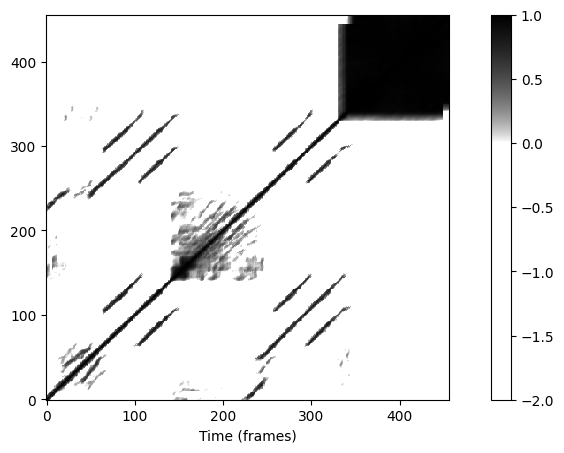

In [8]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(6,5))

plot_matrix(S, Fs=1, Fs_F=1, ax = [axs[0],axs[1]], cmap=cmap_penalty,
                          xlabel='Time (frames)', ylabel='', title='')

## 경로군 (Path Family)

- $P=((n_1,m_1), (n_2,m_2), \ldots,(n_L,m_L))$를 주어진 **세그먼트** $\alpha=[s:t]\subseteq [ 1:N]$의 경로(path)라고 하고, $\Sigma$를 기본 **허용 가능한 step size 집합**을 나타낸다고 하자. 
- 그러면 정의에 따라 $m_1=s$ 및 $m_L=t$ 이고, 경로 $P$는 $\alpha=\pi_2(P)$와 induced 세그먼트 $\pi_1(P)$ 사이의 관계를 인코딩한다. 

- 경로의 개념을 확장하여 이제 음악 녹음에서 $\alpha$와 다른 여러 세그먼트 간의 관계를 캡처할 수 있는 경로군(path family)의 개념을 소개한다. 이를 위해 먼저 $K$ 크기의 **세그먼트 군(segment family)**를 다음의 집합으로 정의한다.
    - $ \mathcal{A}:=\{\alpha_1,\alpha_2,\ldots,\alpha_K\}$

- 즉, $k\not= j$인 모든 $k,j\in[1:K]$에 대해 $\alpha_k\cap\alpha_j=\emptyset$이다. $\alpha$ 위의 **경로군**는 다음의 집합으로 정의된다.
    - $ \mathcal{P}:=\{P_1,P_2,\ldots,P_K\} $
    - of size $K$, consisting of paths $P_k$ over $\alpha$ for $k\in[1:K]$
    
- 또한 추가 조건으로 induced 세그먼트가 pairwise disjoint이어야 한다. 즉, $\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$ 집합이 세그먼트 군이 되어야 한다.
- 이러한 정의는 다음의 그림으로 설명된다.
    - (왼쪽부터) 세그먼트 $\alpha$가 있는 SSM / 세 개의 경로로 구성된 $\alpha$ 위에 경로군가 있이 SSM / 경로군이 **아닌** 경로들(induced 세그먼트가 겹치기 때문에) / 두 개의 경로로 구성된 경로군

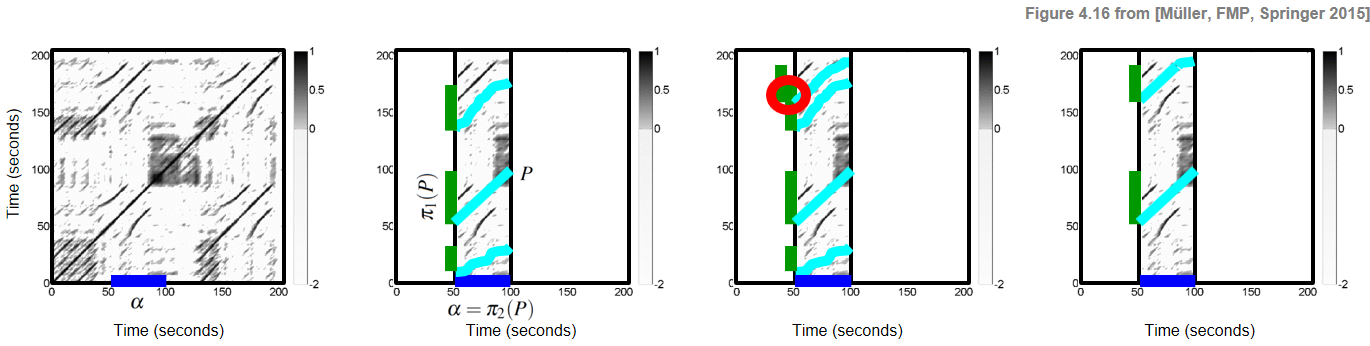

In [9]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_F16.png", width=1000)

In [12]:
def plot_path_family(ax, path_family, Fs=1, x_offset=0, y_offset=0, proj_x=True, w_x=7, proj_y=True, w_y=7):
    """Plot path family into a given axis

    Args:
        ax: Axis of plot
        path_family: Path family
        Fs: Feature rate of path_family (Default value = 1)
        x_offset: Offset x-axis (Default value = 0)
        y_offset: Yffset x-axis (Default value = 0)
        proj_x: Display projection on x-axis (Default value = True)
        w_x: Width used for projection on x-axis (Default value = 7)
        proj_y: Display projection on y-axis (Default value = True)
        w_y: Width used for projection on y-axis (Default value = 7)
    """
    for path in path_family:
        y = [(path[i][0] + y_offset)/Fs for i in range(len(path))]
        x = [(path[i][1] + x_offset)/Fs for i in range(len(path))]
        ax.plot(x, y, "o", color=[0, 0, 0], linewidth=3, markersize=5)
        ax.plot(x, y, '.', color=[0.7, 1, 1], linewidth=2, markersize=6)
    if proj_y:
        for path in path_family:
            y1 = path[0][0]/Fs
            y2 = path[-1][0]/Fs
            ax.add_patch(plt.Rectangle((0, y1), w_y, y2-y1, linewidth=1,
                                       facecolor=[0, 1, 0], edgecolor=[0, 0, 0]))
            # ax.plot([0, 0], [y1, y2], linewidth=8, color=[0, 1, 0])
    if proj_x:
        for path in path_family:
            x1 = (path[0][1] + x_offset)/Fs
            x2 = (path[-1][1] + x_offset)/Fs
            ax.add_patch(plt.Rectangle((x1, 0), x2-x1, w_x, linewidth=1,
                                       facecolor=[0, 0, 1], edgecolor=[0, 0, 0]))
            # ax.plot([x1, x2], [0, 0], linewidth=8, color=[0, 0, 1])                 

Segment: [40, 160]


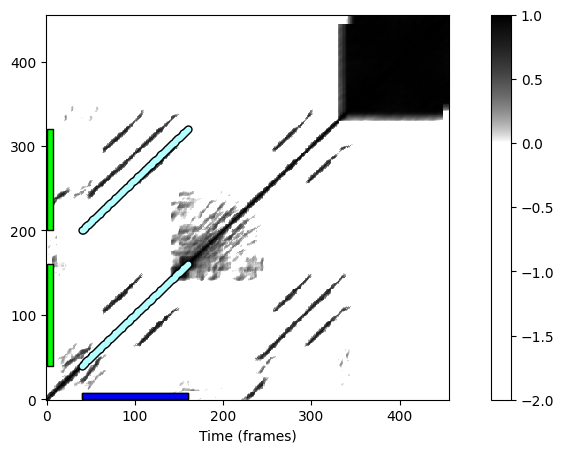

In [17]:
# Manually defined path family
# For implementation reasons, the seconds components are of the paths 
# start with index 0 (corresponding to seg[0])
seg_sec = [20, 80]
seg = [int(seg_sec[0]*Fs_feature), int(seg_sec[1]*Fs_feature)]
path_1 = [np.array([i+seg[0],i]) for i in range(0, seg[-1]-seg[0]+1)]
path_2 = [np.array([int(i+100*Fs_feature),i]) for i in range(0, seg[-1]-seg[0]+1)]
path_family = [path_1, path_2]
print('Segment:', seg)

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(6,5))

plot_matrix(S, Fs=1, Fs_F=1, ax = [axs[0],axs[1]], cmap=cmap_penalty,
                          xlabel='Time (frames)', ylabel='', title='')
plot_path_family(axs[0], path_family, Fs=1, x_offset=seg[0])

## 범위(Coverage)

- 이제 경로군 $\mathcal{P}$의 특정 속성을 설명하는 몇 가지 측정값을 정의한다. 
- $\mathcal{A}:=\{\alpha_1,\alpha_2,\ldots,\alpha_K\}$를 세그먼트 군이라고 하자.
- $\mathcal{A}$의 **범위(coverage)** $\gamma(\mathcal{A})$는 다음과 같이 정의된다.
    - $ \gamma(\mathcal{A}):=\sum_{k=1}^K|\alpha_k|. $

- 또한, 경로군 $\mathcal{P}=\{P_1,P_2,\ldots,P_K\}$의 범위 $\gamma(\mathcal{P})$는 induced 세그먼트 군 $\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$의 범위로 정의된다. 
- 다음 코드에서 induced 세그먼트 군와 주어진 경로군에 대한 커버리지를 유도하는 함수를 제공한다. 이 함수는 위에서 생성한 경로군에 적용된다.

In [24]:
def compute_induced_segment_family_coverage(path_family):
    """Compute induced segment family and coverage from path family

    Args:
        path_family (list): Path family

    Returns:
        segment_family (np.ndarray): Induced segment family
        coverage (float): Coverage of path family
    """
    num_path = len(path_family)
    coverage = 0
    if num_path > 0:
        segment_family = np.zeros((num_path, 2), dtype=int)
        for n in range(num_path):
            segment_family[n, 0] = path_family[n][0][0]
            segment_family[n, 1] = path_family[n][-1][0]
            coverage = coverage + segment_family[n, 1] - segment_family[n, 0] + 1
    else:
        segment_family = np.empty

    return segment_family, coverage

In [25]:
segment_family, coverage = compute_induced_segment_family_coverage(path_family)
print('Segment (alpha):', seg)
print('Induced segment family:')
print(segment_family)
print('Coverage: %d'%coverage)    

Segment (alpha): [82, 136]
Induced segment family:
[[ 82 136]
 [272 327]]
Coverage: 111


## 점수와 최적 (Score and Optimality)

- 다음으로 점수(score)의 개념을 경로에서 경로군로 전환한다. 주어진 SSM $\mathbf{S}$에서 경로 $P$의 **점수** $\sigma(P)$는 다음과 같이 정의된다.
    -$\sigma(P)=\sum_{\ell=1}^L \mathbf{S}(n_\ell,m_\ell).$

- 이 값은 세그먼트 $\pi_1(P)$와 $\pi_2(P)$ 사이의 유사성 관계에 대한 품질 척도로 생각할 수 있다. 경로군 $\mathcal{P}$의 경우 **점수** $\sigma(\mathcal{P})$는 다음과 같이 정의된다.
    - $\sigma(\mathcal{P}) := \sum_{k=1}^{K} \sigma(P_k).$

- 큰 점수 $\sigma(\mathcal{P})$는 $\mathcal{P}$의 경로 구성 요소가 해당 세그먼트 간에 강력한 유사성 관계를 표현함을 나타낸다.

- 일반적으로 많은 수의 $\alpha$위로의 가능한 경로군가 있다. 

- 이러한 경로군 중에서 $\mathcal{P}^\ast := \underset{\mathcal{P}}{\mathrm{argmax}} \,\,\, \sigma(\mathcal{P})$를 최대 점수의 최적 경로군을 나타낸다고 하자. 

- 다음에서는 $\mathcal{P}^\ast$ 경로에 의해 유도된(induced) 세그먼트로 구성된 것을 **유도(induced) 세그먼트 군** (of $\mathcal{P}^\ast$ 또는 간단히 $\alpha$)이라고 한다. 

- 직관적으로, 유도된 세그먼트 군은 세그먼트 $\alpha$의 (겹치지 않는) 반복을 포함한다.

## 최적 경로군 계산 (Computation of Optimal Path Families)

- 최적 워핑 경로를 계산하는 DTW(dynamic time warping)과 유사하게 동적(dynamic) 프로그래밍을 사용하여 최적 경로군 $\mathcal{P}^\ast$를 계산하는 효율적인 알고리즘이 있다. 

- 다음 코드에서 허용 가능한 step size의 $\Sigma = \{(2,1),(1,2),(1,1)\}$ 집합을 사용하여 이 알고리즘의 구현한다. 

- $\mathbf{S}$를 필요한 정규화 속성(**점수 매트릭스**라고도 함)과 세그먼트 $\alpha=[s:t]\subseteq [ 1:N]$와 $M:=|\alpha|$을 충족하는 $N$-square SSM이라고 하자. 

- 알고리즘의 입력(input)은 $\mathbf{S}$의 열 $s$에서 $t$로 구성된 $N\times M$ 부분행렬(submatrix) $\mathcal{S}^{\alpha}$이다. 

- 먼저 동적 프로그래밍을 사용하여 **누적 점수 매트릭스** $D$를 계산한다.

In [26]:
def compute_accumulated_score_matrix(S_seg):
    """Compute the accumulated score matrix

    Args:
        S_seg (np.ndarray): Submatrix of an enhanced and normalized SSM ``S``.
            Note: ``S`` must satisfy ``S(n,m) <= 1 and S(n,n) = 1``

    Returns:
        D (np.ndarray): Accumulated score matrix
        score (float): Score of optimal path family
    """
    inf = math.inf
    N = S_seg.shape[0]
    M = S_seg.shape[1]+1

    # Iinitializing score matrix
    D = -inf * np.ones((N, M), dtype=np.float64)
    D[0, 0] = 0.
    D[0, 1] = D[0, 0] + S_seg[0, 0]

    # Dynamic programming
    for n in range(1, N):
        D[n, 0] = max(D[n-1, 0], D[n-1, -1])
        D[n, 1] = D[n, 0] + S_seg[n, 0]
        for m in range(2, M):
            D[n, m] = S_seg[n, m-1] + max(D[n-1, m-1], D[n-1, m-2], D[n-2, m-1])

    # Score of optimal path family
    score = np.maximum(D[N-1, 0], D[N-1, M-1])

    return D, score

- 다음으로, 백트래킹(backtracking)을 이용하여 최적 경로군 $\mathcal{P}^\ast$를 도출한다. 

In [27]:
def compute_optimal_path_family(D):
    """Compute an optimal path family given an accumulated score matrix

    Args:
        D (np.ndarray): Accumulated score matrix

    Returns:
        path_family (list): Optimal path family consisting of list of paths
            (each path being a list of index pairs)
    """
    # Initialization
    inf = math.inf
    N = int(D.shape[0])
    M = int(D.shape[1])

    path_family = []
    path = []

    n = N - 1
    if(D[n, M-1] < D[n, 0]):
        m = 0
    else:
        m = M-1
        path_point = (N-1, M-2)
        path.append(path_point)

    # Backtracking
    while n > 0 or m > 0:

        # obtaining the set of possible predecesors given our current position
        if(n <= 2 and m <= 2):
            predecessors = [(n-1, m-1)]
        elif(n <= 2 and m > 2):
            predecessors = [(n-1, m-1), (n-1, m-2)]
        elif(n > 2 and m <= 2):
            predecessors = [(n-1, m-1), (n-2, m-1)]
        else:
            predecessors = [(n-1, m-1), (n-2, m-1), (n-1, m-2)]

        # case for the first row. Only horizontal movements allowed
        if n == 0:
            cell = (0, m-1)
        # case for the elevator column: we can keep going down the column or jumping to the end of the next row
        elif m == 0:
            if D[n-1, M-1] > D[n-1, 0]:
                cell = (n-1, M-1)
                path_point = (n-1, M-2)
                if(len(path) > 0):
                    path.reverse()
                    path_family.append(path)
                path = [path_point]
            else:
                cell = (n-1, 0)
        # case for m=1, only horizontal steps to the elevator column are allowed
        elif m == 1:
            cell = (n, 0)
        # regular case
        else:

            # obtaining the best of the possible predecesors
            max_val = -inf
            for i, cur_predecessor in enumerate(predecessors):
                if(max_val < D[cur_predecessor[0], cur_predecessor[1]]):
                    max_val = D[cur_predecessor[0], cur_predecessor[1]]
                    cell = cur_predecessor

            # saving the point in the current path
            path_point = (cell[0], cell[1]-1)
            path.append(path_point)

        (n, m) = cell

    # adding last path to the path family
    path.reverse()
    path_family.append(path)
    path_family.reverse()

    return path_family

- 다음 그림에서 부분 행렬 $\mathcal{S}^{\alpha}$와 세그먼트 $\alpha=[83:137]$ (`seg = [82, 136]`)에 대한 누적 점수 행렬 $D$가 나타나 있다. 
- $2~\mathrm{Hz}$의 프레임 속도(frame rate)를 사용하여 이 세그먼트는 $41$에서 $68$초 범위의 간격에 해당하며 대략적으로 Brahms 레코딩의 $B_1$ 부분이다. 다음 사항에 유의하자.
    * 부분 행렬 $\mathcal{S}^{\alpha}$의 열 수는 $M=55$이다.
    * Python 구현에서 $\mathcal{S}^{\alpha}$의 열은 인덱스 `0`부터 인덱스 `M-1`까지 열거된다.
    * 행렬 $D$에는 소위 엘리베이터(elevator) 컬럼을 포함하는 $M+1$ 컬럼이 있다.
    * 단계 크기(step size) 조건 $\Sigma = \{(2,1),(1,2),(1,1)\}$를 사용하면, 경로가 로컬 템포 차이에 적응할 수 있다.
    * 최적의 경로군은 4개의 경로로 구성된다. 유도된(induced) 세그먼트는 Brahms 녹음의 4개의 $B$ 파트 섹션에 대략 해당된다.
        - 아래의 예시는 2개의 경로!

Segment: [82, 136]
Length of segment: M =  55


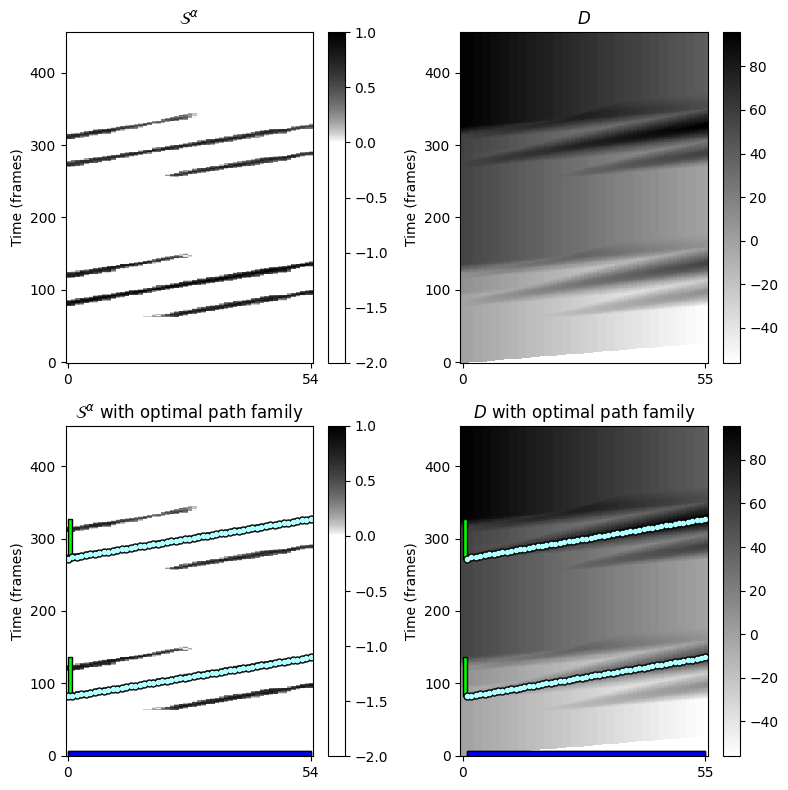

In [28]:
def plot_matrix_seg(ax, M, seg, title='', xlabel='', cmap='gray_r'):
    plot_matrix(M, Fs=1, ax=[ax], cmap=cmap, 
        xlabel=xlabel, ylabel='Time (frames)', title=title)
    ax.set_xticks([0, M.shape[1]-1])    
    
seg_sec = [41,68]
seg = [int(seg_sec[0]*Fs_feature), int(seg_sec[1]*Fs_feature)]
print('Segment:', seg)
print('Length of segment: M = ', seg[1]-seg[0]+1)
S_seg = S[:,seg[0]:seg[1]+1]
D, score = compute_accumulated_score_matrix(S_seg)
path_family = compute_optimal_path_family(D)

plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 2, 1)
title = r'$\mathcal{S}^{\alpha}$'
plot_matrix_seg(ax, S_seg, seg, title=title, xlabel='', cmap=cmap_penalty)

ax = plt.subplot(2, 2, 2)
title = r'$D$'
plot_matrix_seg(ax, D, seg, title=title)

ax = plt.subplot(2, 2, 3)
title = r'$\mathcal{S}^{\alpha}$ with optimal path family'
plot_matrix_seg(ax, S_seg, seg, title=title, xlabel='', cmap=cmap_penalty)
plot_path_family(ax, path_family, x_offset=0, w_y=1)

ax = plt.subplot(2, 2, 4)
title = r'$D$ with optimal path family'
plot_matrix_seg(ax, D, seg, title=title)
plot_path_family(ax, path_family, x_offset=1, w_y=1)

plt.tight_layout()

## 적합도 측정 (Fitness Measure)

- 주어진 세그먼트 $\alpha$에 대해, $\mathcal{P}^\ast=\{P_1,\ldots,P_K\}$를 최적 경로군이라고 하자. 이제 $\sigma(\mathcal{P}^\ast)$ 점수와 $\mathcal{P}^\ast$의 유도된 세그먼트 군에서 적합도(fitness) 측정을 유도하는 방법을 설명한다.

- 첫 번째, 총 점수 $\sigma(\mathcal{P}^\ast)$를 $\alpha$의 적합도 값으로 사용한다. 그러나 이 측정은 $\alpha$의 길이와 경로에 의존할 뿐만 아니라 당연한 자체-설명(self-explanation)도 캡처하기 때문에 아직 원하는 속성을 갖지 않는다.
    - 예를 들어 $\alpha=[1:N]$ 세그먼트는 전체 시퀀스 $X$를 완벽하게 설명하며 이는 당연한 사실이다. 좀 더 일반적으로 각 세그먼트 $\alpha$는 자기 유사성 행렬의 주 대각선으로 인코딩된 정보를 완벽하게 설명한다.

- 따라서 적합도 측정을 정의할 때의 한 가지 방법은 이러한 당연한 자기-설명(trivial self-explanation)을 무시하는 것이다.
    - 정규화 속성 $\mathbf{S}(n,m)\leq 1$ 및 $\mathbf{S}(n,n)=1$를 가정하면, $\sigma(\mathcal{P}^\ast)$ 점수에서 $|\alpha|$ 길이를 빼는 방법을 사용할 수 있다.

- 또한 최적 경로군 $\mathcal{P}^\ast$에 포함된 경로 $P_k$의 길이 $L_k:=|P_k|$에 대한 점수를 정규화한다.
- 이는 다음과 같이 정의된 **정규화 점수(normalized score)** $\bar{\sigma}(\alpha)$를 산출한다.
     - $\bar{\sigma}(\alpha) := \frac{\sigma(\mathcal{P}^\ast) - |\alpha|}{\sum_{k=1}^{K} L_k}. $

- 직관적으로 $\bar{\sigma}(\alpha)$ 값은 최적 경로군 $\mathcal{P}^\ast$의 **평균 점수**를 나타낸다. .
- 정규화 점수는 주어진 세그먼트가 다른 세그먼트를 **얼마나 잘 (how well)** 설명하는지를 나타내며, 여기서 정규화는 세그먼트 길이의 영향을 제거한다. 이렇게 하면 길이가 다른 세그먼트를 비교할 때 정규화된 점수가 공정한 측정이 될 수 있다.

- 반복성 외에 또 다른 문제는 썸네일 및 썸네일 관련 세그먼트가 기본 음악 녹음을 **얼마나 많이 (how much)** 포함하는지이다.
- 이 속성을 포착하기 위해 주어진 $\alpha$에 대한 **범위/커버리지(coverage)** 측정을 정의한다.
- 이를 위해 $\mathcal{A}^\ast:=\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$를 최적 경로군 $\mathcal{P}^\ast$에 의해 유도된 세그먼트 군이라고 하고, $\gamma(\mathcal{A}^\ast)$를 그것의 범위라고 하자.
- 그런 다음 **정규화 범위** $\bar{\gamma}(\alpha)$를 다음과 같이 정의한다.
     - $\bar{\gamma}(\alpha) := \frac{\gamma(\mathcal{A}^\ast) - |\alpha|}{N}.$

- 위와 같이 사소한(trivial) 범위를 보상하기 위해 $|\alpha|$ 길이를 뺀다.
- $\bar{\gamma}(\alpha)$ 값은 $\alpha$의 induced 세그먼트의 합집합과 원본 녹음의 전체 길이 사이의 비율을 나타낸다(자체-설명의 비율을 뺀 값).
- 높은 평균 점수와 높은 커버리지는 썸네일 세그먼트를 정의하는 데 바람직한 속성이다.
- 그러나 이 두 가지 속성을 동시에 만족시키기 어려운 경우가 있다. 세그먼트가 짧을수록 평균 점수는 더 높지만 적용 범위는 더 낮고, 길이가 더 긴 세그먼트는 평균 점수가 더 낮지만 적용 범위가 더 높은 경향이 있다.
- 이 두 추세의 균형을 맞추기 위해 적절한 평균을 취하여 점수와 범위 측정을 결합한다.
- 특히 세그먼트 $\alpha$의 **적합도(fitness)** $\varphi(\alpha)$를 정규화된 점수와 정규화된 적용 범위 사이의 **조화 평균 (harmonic mean)** $\varphi(\alpha) := 2\cdot \frac{\bar{\sigma}(\alpha) \cdot \bar{\gamma}(\alpha)}{\bar{\sigma}(\alpha)+\bar{\gamma}(\alpha )}$ 라고 정의한다.
- 정규화된 값 $\bar{\sigma}(\alpha)$ 및 $\bar{\gamma}(\alpha)$를 기반으로, $\varphi(\alpha)\leq 1-|\alpha |/N$ 임을 보일 수 있다.

- 다음 코드 셀에서는 이전 코드 셀에서 고려한 경로군에 대해 이러한 다양한 측정값을 계산한다.

In [29]:
def compute_fitness(path_family, score, N):
    """Compute fitness measure and other metrics from path family

    Args:
        path_family (list): Path family
        score (float): Score
        N (int): Length of feature sequence

    Returns:
        fitness (float): Fitness
        score (float): Score
        score_n (float): Normalized score
        coverage (float): Coverage
        coverage_n (float): Normalized coverage
        path_family_length (int): Length of path family (total number of cells)
    """
    eps = 1e-16
    num_path = len(path_family)
    M = path_family[0][-1][1] + 1

    # Normalized score
    path_family_length = 0
    for n in range(num_path):
        path_family_length = path_family_length + len(path_family[n])
    score_n = (score - M) / (path_family_length + eps)

    # Normalized coverage
    segment_family, coverage = compute_induced_segment_family_coverage(path_family)
    coverage_n = (coverage - M) / (N + eps)

    # Fitness measure
    fitness = 2 * score_n * coverage_n / (score_n + coverage_n + eps)

    return fitness, score, score_n, coverage, coverage_n, path_family_length

In [30]:
N = S.shape[0]

segment_family, coverage = compute_induced_segment_family_coverage(path_family)
fitness, score, score_n, coverage, coverage_n, path_family_length = compute_fitness(
    path_family, score, N)

print('Segment (alpha):', seg)
print('Length of segment:', seg[-1]-seg[0]+1)
print('Length of feature sequence:', N)
print('Induced segment path family:\n', segment_family)
print('Fitness: %0.3f'%fitness) 
print('Score: %0.3f'%score) 
print('Normalized score: %0.3f'%score_n) 
print('Coverage: %d'%coverage) 
print('Normalized coverage: %0.3f'%coverage_n) 
print('Length of all paths of family: %d'%path_family_length)

Segment (alpha): [82, 136]
Length of segment: 55
Length of feature sequence: 456
Induced segment path family:
 [[ 82 136]
 [272 327]]
Fitness: 0.184
Score: 95.630
Normalized score: 0.369
Coverage: 111
Normalized coverage: 0.123
Length of all paths of family: 110


## 썸네일 선정 (Thumbnail Selection)

- 피트니스 측정을 기반으로 **오디오 썸네일**을 **최대 적합도** 세그먼트로 정의한다.
     - $ \alpha^\ast := \underset{\alpha}{\mathrm{argmax}} \,\, \varphi(\alpha).$
- 적합도 측정으로 이 세그먼트는 오디오 녹음의 "가능한 많은 부분을 포함하는 겹치지 않는 반복"을 가지게 된다.
- 또한 이러한 반복은 오디오 녹음을 pairwise disjoint 세그먼트로 분할하는 $\alpha^\ast$의 최적 경로군으로 얻은 induced 세그먼트에 의해 주어진다.
- 사전 지식을 설명하고 잘못된 추정을 제거하기 위해 썸네일 솔루션에 추가 요구 사항을 부과할 수 있다.
- 가능한 최소 썸네일 길이에 대한 하한 $\theta$를 도입하면 자기 유사성 행렬(SSM)에 분산된 노이즈의 영향을 줄일 수 있다.
- 위의 정의를 확장하여 $ \alpha^\ast_\theta := \underset{\alpha, |\alpha|\geq \theta}{\mathrm{argmax}} \,\, \varphi(\alpha)$를 정의한다. 

- 오디오 썸네일 계산에는 가능한 모든 세그먼트 $\alpha$에 대한 피트니스 측정 계산이 포함된다.
- 적합도 최대화 세그먼트를 선택하는 것 외에도 모든 세그먼트에 대한 적합도 값의 시각화는 매우 유익하며 음악 녹음의 구조적 속성에 대한 음악적 통찰력을 제공한다. 그 중 경관도(scape plot)에 대해 뒤에서 다룰 것이며, 여기서 적합도 측정의 추가 속성에 대해서도 논의하기로 한다.

## Examples of Optimal Path Families

# Scape Plot

## Triangular Representation of Segments

In the context of [audio thumbnailing](../C4/C4S3_AudioThumbnailing.html), we computed a [fitness measure](../C4/C4S3_AudioThumbnailing.html) that assigns to each possible segment a fitness value expressing a segment-specific property. We now introduce a representation by which a segment-dependent property can be visualized in a compact and hierarchical way. Recall that a **segment** $\alpha=[s:t]\subseteq [1:N]$ is uniquely determined by its starting point $s$ and its end point $t$. Since any two numbers $s,t\in[1:N]$ with $s\leq t$ define a segment, there are $(N+1)N/2$ different segments. Instead of considering start and end points, each segment can also be uniquely described by its center 

$$
   c(\alpha):=(s+t)/2
$$

and its length $|\alpha|$. Using the center to parameterize a horizontal axis and the length to parameterize the height, each segment can be represented by a point in a **triangular representation**. This way, the set of segments are ordered from bottom to top in a hierarchical way according to their length. In particular, the top of this triangle corresponds to the unique segment of maximal length $N$ and the bottom points of the triangle correspond to the $N$ segments of length one (where the start point coincides with the end point). Furthermore, all segments $\alpha'\subseteq\alpha$ contained in a given segment $\alpha$ correspond to points in the triangular representation that lie in a subtriangle below the point given by $\alpha$

<img src="../data/C4/FMP_C4_F19.png" width="400x" align="middle" alt="FMP_C8_F19">

Given a triangular representation of all segments within $[1:N]$, the following example visually indicates the following sets of segments (see Exercise 4.12 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>):

(a) All segments having a minimal length above a given threshold $\theta\geq 0$<br/> 
(b) All segments that contain a given segment $\alpha$<br/>
(c) All segments that are disjoint to a given segment $\alpha$<br/>
(d) All segments that contain the center $c(\alpha)$ of a given segment $\alpha$


<img src="../data/C4/FMP_C4_E12.png" width="500x" align="middle" alt="FMP_C4_E12.png">

## Scape Plot

The triangular representation can be used as a grid for visualizing a specific numeric property $\varphi(\alpha)\in\mathbb{R}$ that can be computed for all segments $\alpha$. This property, for example, can be the fitness values as used for <a href="../C4/C4S3_AudioThumbnailing.html">audio thumbnailing</a> (see Section 4.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>). Such a visual representation is also referred to as **scape plot** representation of the property. More precisely, we define a scape plot $\Delta$ by setting 

\begin{equation}
\label{eq:AudioStru:Thumb:SPfitness}
   \Delta(c(\alpha),|\alpha|):=\varphi(\alpha)
\end{equation}

for segment $\alpha$. As a toy example, we consider the function $\varphi$ defined by $\varphi(\alpha):= (t-s+1)/N$ for $\alpha=[s:t]$, which encodes the segment lengths relative to the total length $N$. In the following code cell, we provide a visualization function for plotting a scape plot representation of this function. 

<div class="alert alert-block alert-warning">
<strong>Note:</strong> In our implementation, we use an <code>N</code>-square matrix <code>SP</code> as data structure to the store the segment-dependent property $\varphi(\alpha)\in\mathbb{R}$. We use the first dimension of <code>SP</code> to encode the length and the second one to encode the center. Since indexing in Python starts with index <code>0</code>, one needs to be careful when interpreting the length dimension. In particular, the entry <code>SP[length_minus_one, start]</code> contains the information for the segment having length <code>length_minus_one + 1</code> for <code>length_minus_one = 0, ..., N-1</code>. Furthermore, note that only the left-upper part (including the diagonal) of <code>SP</code> is used.
</div>